In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Load the Titanic dataset
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

# Show the first few rows of the training dataset
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
#pip install lightgbm xgboost

In [27]:
# Combine for consistent preprocessing
combined_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
combined_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [28]:
# Check for missing values in the training dataset
missing_values = combined_df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

Cabin       1014
Survived     418
Age          263
Embarked       2
Fare           1
dtype: int64

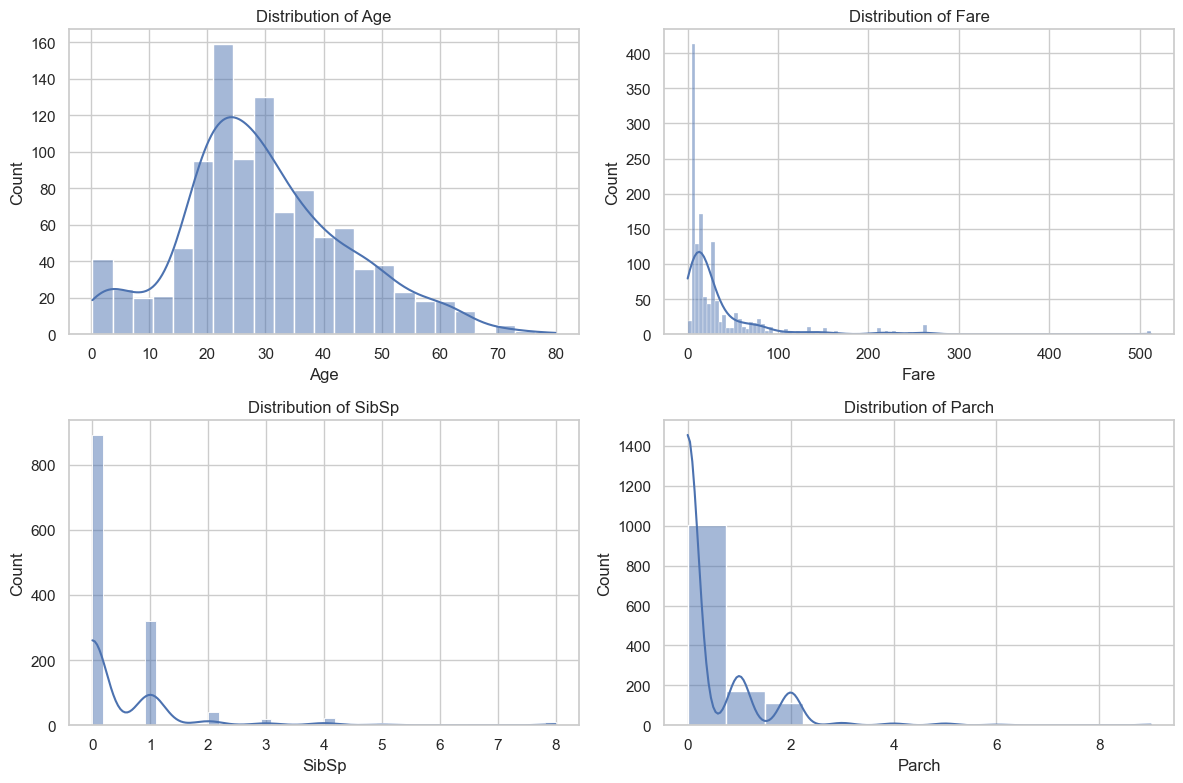

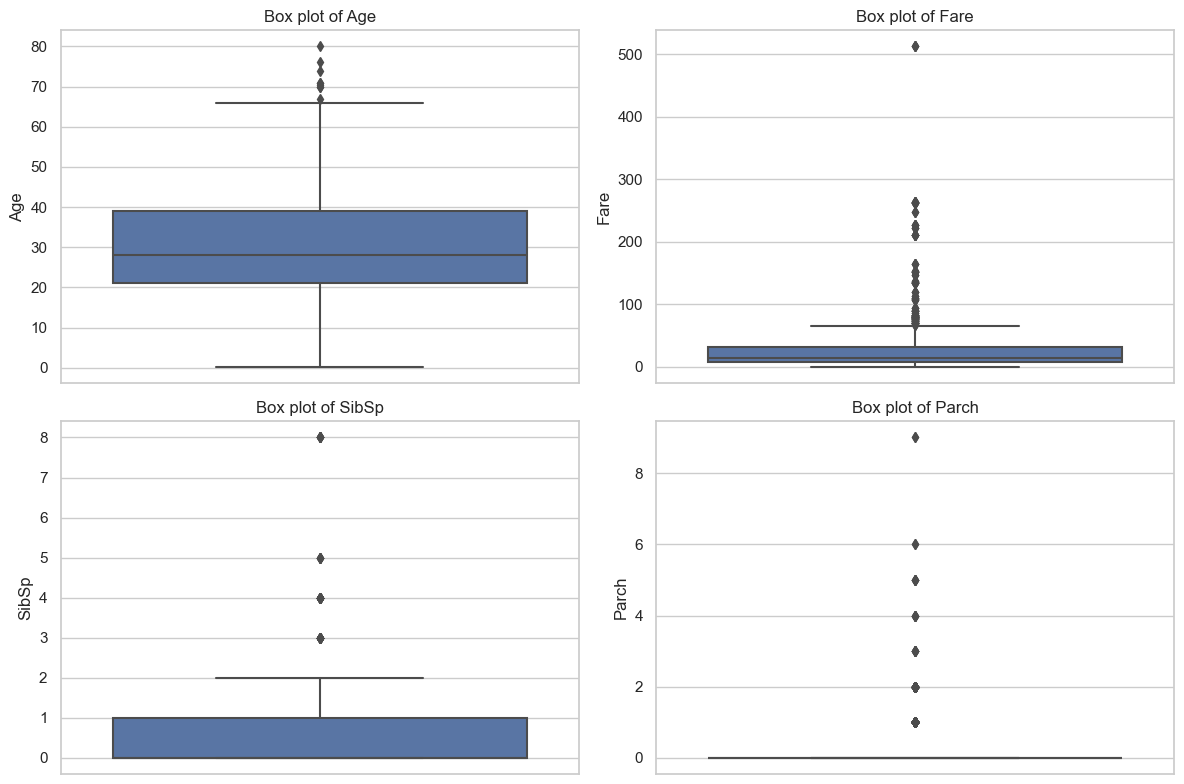

In [29]:
# Set the plotting style
sns.set(style="whitegrid")

# Histograms for numerical features
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(combined_df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Box plots to detect outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=combined_df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()


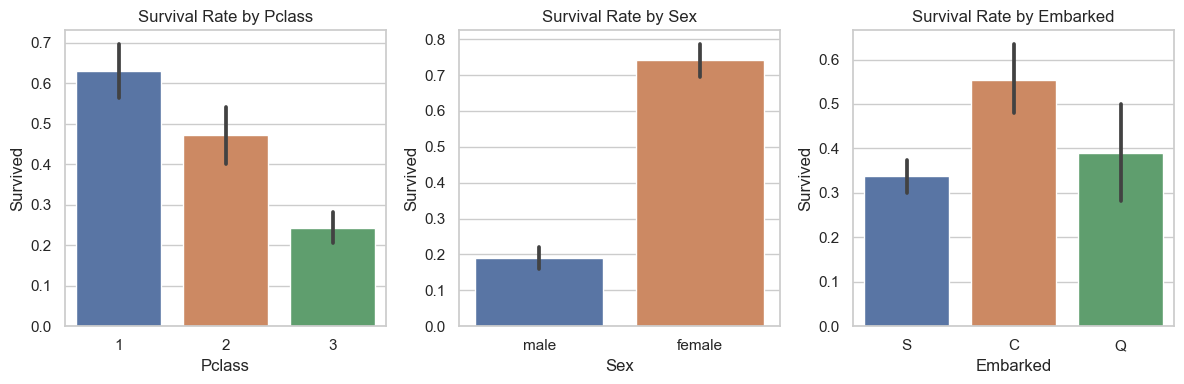

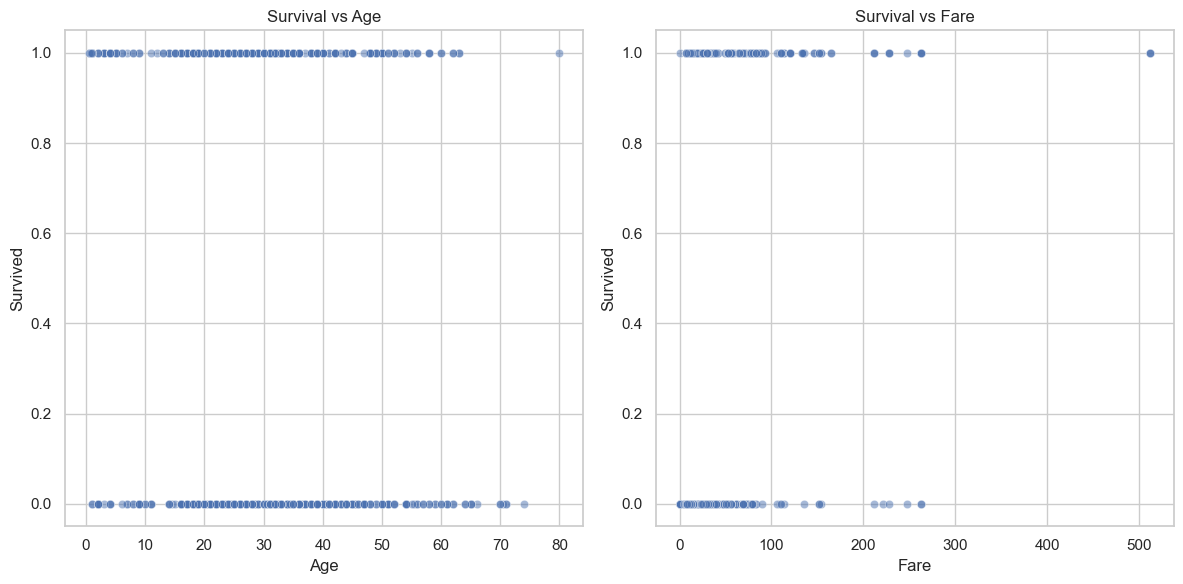

In [22]:
# Bar plots for categorical features vs survival
categorical_features = ['Pclass', 'Sex', 'Embarked']

plt.figure(figsize=(12, 4))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x=col, y='Survived', data=combined_df)
    plt.title(f'Survival Rate by {col}')
plt.tight_layout()
plt.show()

# Scatter plots for numerical features vs survival
plt.figure(figsize=(12, 6))
for i, col in enumerate(['Age', 'Fare'], 1):
    plt.subplot(1, 2, i)
    sns.scatterplot(x=col, y='Survived', data=combined_df, alpha=0.5)
    plt.title(f'Survival vs {col}')
plt.tight_layout()
plt.show()


In [30]:
# Fill missing values
combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
combined_df['Embarked'].fillna(combined_df['Embarked'].mode()[0], inplace=True)
combined_df['Cabin'] = combined_df['Cabin'].fillna('Missing').apply(lambda x: x[0])
combined_df['Survived'].fillna(combined_df['Survived'].median(), inplace=True)
combined_df['Fare'].fillna(combined_df['Fare'].median(), inplace=True)

In [31]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in ['Sex', 'Embarked', 'Cabin']:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])
    label_encoders[col] = le

# Drop irrelevant columns
combined_df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [32]:
# Split back
train_processed = combined_df[:len(train_df)]
test_processed = combined_df[len(train_df):]

# Define features and target
X = train_processed.drop(['Survived'], axis=1)
y = train_processed['Survived']

In [33]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lgbm_model = LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train models
lgbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\91980\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:04:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [34]:
# Predictions
lgbm_preds = lgbm_model.predict(X_val)
xgb_preds = xgb_model.predict(X_val)


In [47]:
# Evaluation
def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

lgbm_metrics = evaluate_model(y_val, lgbm_preds)
xgb_metrics = evaluate_model(y_val, xgb_preds)
print("Light", lgbm_metrics)
print("XG", xgb_metrics)

Light {'Accuracy': 0.8156424581005587, 'Precision': 0.7733333333333333, 'Recall': 0.7837837837837838, 'F1 Score': 0.7785234899328859}
XG {'Accuracy': 0.7821229050279329, 'Precision': 0.7333333333333333, 'Recall': 0.7432432432432432, 'F1 Score': 0.738255033557047}


In [36]:
# Combine metrics for visualization
metrics_df = pd.DataFrame([lgbm_metrics, xgb_metrics], index=['LightGBM', 'XGBoost'])

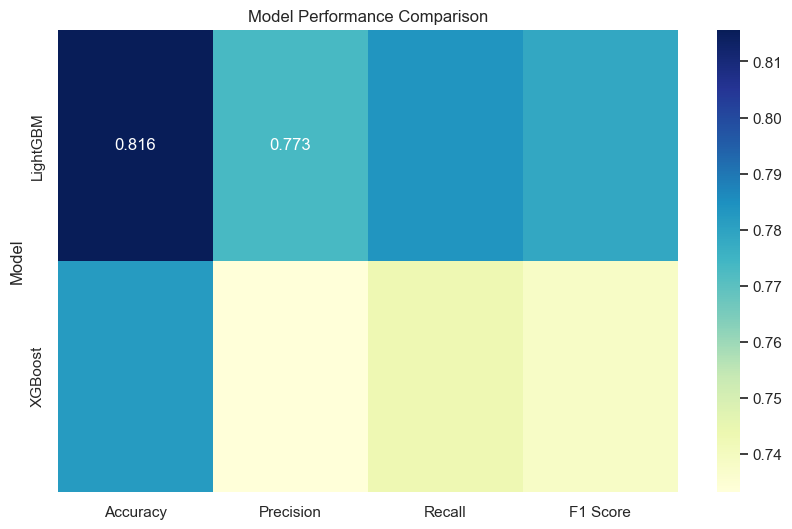

In [49]:
# Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Model Performance Comparison")
plt.ylabel("Model")
plt.show()

In [38]:
# Print summary
print("Comparative Analysis Summary:")
print(metrics_df)

Comparative Analysis Summary:
          Accuracy  Precision    Recall  F1 Score
LightGBM  0.815642   0.773333  0.783784  0.778523
XGBoost   0.782123   0.733333  0.743243  0.738255
